# NB01: Integration & Dark Matter Census

**Goal**: Build a unified dark gene table by loading and merging all existing data products from prior observatory projects, then querying the Fitness Browser for fitness phenotype summaries and co-fitness partners.

**Requires**: BERDL JupyterHub (Spark access for FB queries)

**Inputs**:
- `conservation_vs_fitness/data/fb_pangenome_link.tsv` — 177,863 gene-to-cluster links
- `conservation_vs_fitness/data/organism_mapping.tsv` — FB orgId → GTDB species clade
- `fitness_modules/data/modules/*_gene_membership.csv` — ICA module membership (32 organisms)
- `fitness_modules/data/predictions/*_predictions.csv` — Function predictions (32 organisms)
- `fitness_modules/data/module_families/module_families.csv` — Module-to-family mapping
- `essential_genome/data/all_ortholog_groups.csv` — Ortholog group membership
- `essential_genome/data/essential_families.tsv` — Essentiality classification per OG
- `essential_genome/data/essential_predictions.tsv` — Function predictions for essential hypotheticals
- Fitness Browser tables via Spark SQL

**Output**: `data/dark_genes_integrated.tsv`

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Spark session
spark = get_spark_session()

# Project paths — resolve robustly regardless of cwd
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
    REPO_ROOT = os.path.dirname(os.path.dirname(PROJECT_DIR))
else:
    # Fallback: search upward for PROJECT.md
    PROJECT_DIR = os.getcwd()
    _d = PROJECT_DIR
    REPO_ROOT = PROJECT_DIR
    while _d != '/':
        if os.path.exists(os.path.join(_d, 'PROJECT.md')):
            REPO_ROOT = _d
            break
        _d = os.path.dirname(_d)

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# Upstream project paths
CVF_DATA = os.path.join(REPO_ROOT, 'projects', 'conservation_vs_fitness', 'data')
FM_DATA = os.path.join(REPO_ROOT, 'projects', 'fitness_modules', 'data')
EG_DATA = os.path.join(REPO_ROOT, 'projects', 'essential_genome', 'data')

print(f"Project dir: {PROJECT_DIR}")
print(f"Repo root: {REPO_ROOT}")
print(f"CVF data exists: {os.path.exists(CVF_DATA)}")
print(f"FM data exists: {os.path.exists(FM_DATA)}")
print(f"EG data exists: {os.path.exists(EG_DATA)}")

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter
Repo root: /home/aparkin/BERIL-research-observatory
CVF data exists: True
FM data exists: True
EG data exists: True


## 1. Load Existing Data Products

### 1.1 FB-Pangenome Link Table (from conservation_vs_fitness)

In [2]:
# Load FB-pangenome link: 177,863 gene-to-cluster links, 44 organisms
link_df = pd.read_csv(os.path.join(CVF_DATA, 'fb_pangenome_link.tsv'), sep='\t')
print(f"FB-pangenome link: {len(link_df):,} gene-cluster links")
print(f"Organisms: {link_df['orgId'].nunique()}")
print(f"Columns: {list(link_df.columns)}")
print(f"\nConservation breakdown:")
print(f"  Core: {link_df['is_core'].sum():,} ({100*link_df['is_core'].mean():.1f}%)")
print(f"  Auxiliary: {link_df['is_auxiliary'].sum():,} ({100*link_df['is_auxiliary'].mean():.1f}%)")
print(f"  Singleton: {link_df['is_singleton'].sum():,} ({100*link_df['is_singleton'].mean():.1f}%)")
link_df.head(3)

FB-pangenome link: 177,863 gene-cluster links
Organisms: 44
Columns: ['orgId', 'locusId', 'gene_cluster_id', 'gtdb_species_clade_id', 'pident', 'evalue', 'bitscore', 'is_core', 'is_auxiliary', 'is_singleton']

Conservation breakdown:
  Core: 145,821 (82.0%)
  Auxiliary: 32,042 (18.0%)
  Singleton: 7,574 (4.3%)


,orgId,locusId,gene_cluster_id,gtdb_species_clade_id,pident,evalue,bitscore,is_core,is_auxiliary,is_singleton
0,ANA3,7022495,NC_008573.1_1,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,1.210000e-213,585.0,False,True,True
1,ANA3,7022496,NC_008573.1_2,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,2.580000e-50,149.0,False,True,True
2,ANA3,7022497,NC_008573.1_3,s__Shewanella_sp000203935--RS_GCF_000203935.1,100.0,2.080000e-241,653.0,False,True,True


In [3]:
# Organism mapping: FB orgId -> GTDB species clade
org_map = pd.read_csv(os.path.join(CVF_DATA, 'organism_mapping.tsv'), sep='\t')
print(f"Organism mapping: {len(org_map)} organisms")
org_map.head(3)

Organism mapping: 498 organisms


,orgId,genus,species,strain,taxonomyId,gtdb_species_clade_id,pg_genome_id,match_method
0,ANA3,Shewanella,sp.,ANA-3,94122,s__Shewanella_sp000203935--RS_GCF_000203935.1,RS_GCF_000203935.1,taxid
1,BFirm,Burkholderia,phytofirmans,PsJN,398527,s__Paraburkholderia_phytofirmans--RS_GCF_00002...,RS_GCF_000020125.1,taxid
2,Btheta,Bacteroides,thetaiotaomicron,VPI-5482,226186,s__Bacteroides_thetaiotaomicron--RS_GCF_000011...,RS_GCF_000011065.1,taxid


### 1.2 ICA Module Membership & Predictions (from fitness_modules)

In [4]:
# Load module membership for all 32 organisms
membership_files = glob.glob(os.path.join(FM_DATA, 'modules', '*_gene_membership.csv'))
print(f"Found {len(membership_files)} organism module membership files")

module_membership = []
for f in membership_files:
    orgId = os.path.basename(f).replace('_gene_membership.csv', '')
    df = pd.read_csv(f)
    module_cols = [c for c in df.columns if c.startswith('M')]
    # Vectorized melt instead of row-by-row iteration
    df_melted = df.melt(id_vars='locusId', value_vars=module_cols, 
                         var_name='module', value_name='member')
    df_melted = df_melted[df_melted['member'] == 1].drop(columns='member')
    df_melted['orgId'] = orgId
    df_melted['locusId'] = df_melted['locusId'].astype(str)
    module_membership.append(df_melted[['orgId', 'locusId', 'module']])

module_df = pd.concat(module_membership, ignore_index=True)
print(f"Total gene-module assignments: {len(module_df):,}")
print(f"Unique genes in modules: {module_df.groupby('orgId')['locusId'].nunique().sum():,}")
print(f"Organisms: {module_df['orgId'].nunique()}")
module_df.head(3)

Found 32 organism module membership files


Total gene-module assignments: 34,324
Unique genes in modules: 30,688
Organisms: 32


,orgId,locusId,module
0,Cola,Echvi_0060,M000
1,Cola,Echvi_0061,M000
2,Cola,Echvi_0062,M000


In [5]:
# Load module-to-family mapping
mod_families = pd.read_csv(os.path.join(FM_DATA, 'module_families', 'module_families.csv'))
print(f"Module-family mapping: {len(mod_families)} entries")
print(f"Unique families: {mod_families['familyId'].nunique()}")

# Load family annotations
fam_annot = pd.read_csv(os.path.join(FM_DATA, 'module_families', 'family_annotations.csv'))
print(f"Family annotations: {len(fam_annot)}")
fam_annot.head(3)

Module-family mapping: 1114 entries
Unique families: 749
Family annotations: 156


,familyId,n_organisms,n_modules,consensus_term,consensus_db,term_organisms,mean_fdr
0,F001,2,2,PF05136,PFam,2,0.000326
1,F026,3,3,PF00148,PFam,3,0.000180
2,F029,2,2,unannotated,NaN,0,1.000000


In [6]:
# Load function predictions for hypothetical proteins (from fitness_modules)
pred_files = glob.glob(os.path.join(FM_DATA, 'predictions', '*_predictions.csv'))
print(f"Found {len(pred_files)} prediction files")

fm_preds = []
for f in pred_files:
    df = pd.read_csv(f)
    fm_preds.append(df)

fm_preds_df = pd.concat(fm_preds, ignore_index=True)
print(f"Total module-based function predictions: {len(fm_preds_df):,}")
print(f"Unique genes with predictions: {fm_preds_df.groupby('orgId')['locusId'].nunique().sum():,}")
print(f"Columns: {list(fm_preds_df.columns)}")
fm_preds_df.head(3)

Found 32 prediction files
Total module-based function predictions: 6,691
Unique genes with predictions: 6,691
Columns: ['orgId', 'locusId', 'sysName', 'original_desc', 'module', 'gene_weight', 'predicted_function', 'prediction_source', 'annotation_db', 'enrichment_fdr', 'familyId', 'family_n_organisms', 'confidence', 'predicted_function_desc']


,orgId,locusId,sysName,original_desc,module,gene_weight,predicted_function,prediction_source,annotation_db,enrichment_fdr,familyId,family_n_organisms,confidence,predicted_function_desc
0,BFirm,BPHYT_RS19100,BPHYT_RS19100,hypothetical protein,M007,0.834367,PF00460,family,PFam,3.172766e-08,F070,15,9.189315,Flg_bb_rod
1,BFirm,BPHYT_RS36000,BPHYT_RS36000,hypothetical protein,M007,0.674902,PF00460,family,PFam,3.172766e-08,F070,15,7.433044,Flg_bb_rod
2,BFirm,BPHYT_RS22385,BPHYT_RS22385,hypothetical protein,M006,0.850999,PF01012,family,PFam,5.539283e-04,F274,6,3.290940,ETF


### 1.3 Ortholog Families & Essentiality (from essential_genome)

In [7]:
# Ortholog group membership
og_df = pd.read_csv(os.path.join(EG_DATA, 'all_ortholog_groups.csv'))
print(f"Ortholog group membership: {len(og_df):,} entries")
print(f"Unique OGs: {og_df['OG_id'].nunique():,}")
print(f"Organisms: {og_df['orgId'].nunique()}")

# Essentiality classification per OG
ess_df = pd.read_csv(os.path.join(EG_DATA, 'essential_families.tsv'), sep='\t')
print(f"\nEssential families: {len(ess_df):,}")
print(f"Essentiality classes:")
print(ess_df['essentiality_class'].value_counts())

# Function predictions for essential hypotheticals
ess_preds = pd.read_csv(os.path.join(EG_DATA, 'essential_predictions.tsv'), sep='\t')
print(f"\nEssential gene function predictions: {len(ess_preds):,}")
ess_preds.head(3)

Ortholog group membership: 179,237 entries
Unique OGs: 17,222
Organisms: 48



Essential families: 17,222


Essentiality classes:
essentiality_class
never_essential          11564
variably_essential        4799
universally_essential      859
Name: count, dtype: int64

Essential gene function predictions: 1,382


,target_orgId,target_locusId,target_desc,OG_id,source_orgId,source_locusId,source_module,predicted_term,predicted_db,enrichment_fdr,familyId,family_n_organisms,family_consensus,confidence
0,BFirm,BPHYT_RS31975,hypothetical protein,OG00032,Koxy,BWI76_RS15480,M016,PF00356,PFam,6.285406e-18,F511,5,PF00356,17.900637
1,Burk376,H281DRAFT_03269,protein of unknown function (DUF4154),OG03719,pseudo6_N2E2,Pf6N2E2_3457,M024,TIGR00254,TIGRFam,9.930740e-17,F691,3,PF00990,16.480140
2,PS,Dsui_2865,hypothetical protein,OG03719,pseudo6_N2E2,Pf6N2E2_3457,M024,TIGR00254,TIGRFam,9.930740e-17,F691,3,PF00990,16.480140


## 2. Query Fitness Browser for Gene Annotations & Fitness Phenotypes

### 2.1 All FB Genes with Descriptions

In [8]:
# Get all FB genes — 228K rows, small enough to collect
fb_genes = spark.sql("""
    SELECT orgId, locusId, sysName, gene, desc
    FROM kescience_fitnessbrowser.gene
""").toPandas()

# Ensure string types
fb_genes['locusId'] = fb_genes['locusId'].astype(str)
fb_genes['desc'] = fb_genes['desc'].fillna('')

print(f"Total FB genes: {len(fb_genes):,}")
print(f"Organisms: {fb_genes['orgId'].nunique()}")
fb_genes.head(3)

Total FB genes: 228,709
Organisms: 48


,orgId,locusId,sysName,gene,desc
0,acidovorax_3H11,Ac3H11_1,NaN,NaN,"Transcriptional regulator, AraC family"
1,acidovorax_3H11,Ac3H11_2,NaN,NaN,Macrophage infectivity potentiator-related pro...
2,acidovorax_3H11,Ac3H11_3,NaN,NaN,Glycine cleavage system transcriptional activator


In [9]:
# Classify annotation status
def classify_annotation(desc):
    desc_lower = desc.lower().strip()
    if desc_lower == '' or desc_lower == 'null':
        return 'no_annotation'
    elif 'hypothetical protein' in desc_lower:
        return 'hypothetical'
    elif 'duf' in desc_lower:
        return 'DUF'
    elif 'uncharacterized' in desc_lower or 'unknown function' in desc_lower:
        return 'uncharacterized'
    elif 'conserved protein' in desc_lower or 'putative' in desc_lower:
        return 'partial'
    else:
        return 'annotated'

fb_genes['annotation_class'] = fb_genes['desc'].apply(classify_annotation)

# Define "dark" = not annotated
fb_genes['is_dark'] = fb_genes['annotation_class'].isin(['no_annotation', 'hypothetical', 'DUF', 'uncharacterized'])

print("Annotation class distribution:")
class_counts = fb_genes['annotation_class'].value_counts()
for cls, count in class_counts.items():
    pct = 100 * count / len(fb_genes)
    print(f"  {cls}: {count:,} ({pct:.1f}%)")

print(f"\nTotal dark genes: {fb_genes['is_dark'].sum():,} ({100*fb_genes['is_dark'].mean():.1f}%)")

Annotation class distribution:
  annotated: 164,639 (72.0%)
  hypothetical: 48,470 (21.2%)
  partial: 7,059 (3.1%)
  DUF: 3,675 (1.6%)
  uncharacterized: 3,490 (1.5%)
  no_annotation: 1,376 (0.6%)

Total dark genes: 57,011 (24.9%)


### 2.2 Specific Phenotypes (pre-computed strong condition-specific effects)

In [10]:
# Specific phenotypes — 38K entries, genes with strong condition-specific fitness effects
spec_pheno = spark.sql("""
    SELECT orgId, locusId, expName
    FROM kescience_fitnessbrowser.specificphenotype
""").toPandas()
spec_pheno['locusId'] = spec_pheno['locusId'].astype(str)

# Count specific phenotypes per gene
spec_counts = spec_pheno.groupby(['orgId', 'locusId']).size().reset_index(name='n_specific_phenotypes')
print(f"Specific phenotype entries: {len(spec_pheno):,}")
print(f"Genes with specific phenotypes: {len(spec_counts):,}")

Specific phenotype entries: 38,525
Genes with specific phenotypes: 14,934


### 2.3 Fitness Summary Statistics per Gene

For each gene, compute: max |fitness|, number of conditions with |fit| > 1 and |t| > 3, and the condition class with strongest effect.

In [11]:
# Get fitness summary per gene — aggregate in Spark to avoid collecting 27M rows
fitness_summary = spark.sql("""
    SELECT 
        gf.orgId,
        gf.locusId,
        MAX(ABS(CAST(gf.fit AS FLOAT))) as max_abs_fit,
        MIN(CAST(gf.fit AS FLOAT)) as min_fit,
        SUM(CASE WHEN ABS(CAST(gf.fit AS FLOAT)) > 1 AND ABS(CAST(gf.t AS FLOAT)) > 3 THEN 1 ELSE 0 END) as n_strong_conditions,
        SUM(CASE WHEN ABS(CAST(gf.fit AS FLOAT)) > 2 AND ABS(CAST(gf.t AS FLOAT)) > 4 THEN 1 ELSE 0 END) as n_very_strong_conditions,
        COUNT(*) as n_experiments
    FROM kescience_fitnessbrowser.genefitness gf
    GROUP BY gf.orgId, gf.locusId
""").toPandas()

fitness_summary['locusId'] = fitness_summary['locusId'].astype(str)
print(f"Fitness summary: {len(fitness_summary):,} genes")
print(f"Genes with any strong condition (|fit|>1, |t|>3): {(fitness_summary['n_strong_conditions'] > 0).sum():,}")
print(f"Genes with very strong condition (|fit|>2, |t|>4): {(fitness_summary['n_very_strong_conditions'] > 0).sum():,}")

Fitness summary: 182,447 genes
Genes with any strong condition (|fit|>1, |t|>3): 55,836
Genes with very strong condition (|fit|>2, |t|>4): 26,307


### 2.4 Condition-Class Profile for Dark Genes with Strong Effects

Which experiment groups (stress, carbon source, nitrogen source, etc.) cause the strongest fitness defects for each gene?

In [12]:
# Get condition-class profile for genes with strong effects
# Only query genes with |fit| > 2, |t| > 4 to keep result manageable
condition_profile = spark.sql("""
    SELECT 
        gf.orgId,
        gf.locusId,
        e.expGroup,
        MIN(CAST(gf.fit AS FLOAT)) as min_fit_in_group,
        MAX(ABS(CAST(gf.fit AS FLOAT))) as max_abs_fit_in_group,
        SUM(CASE WHEN ABS(CAST(gf.fit AS FLOAT)) > 2 AND ABS(CAST(gf.t AS FLOAT)) > 4 THEN 1 ELSE 0 END) as n_strong_in_group
    FROM kescience_fitnessbrowser.genefitness gf
    JOIN kescience_fitnessbrowser.experiment e
        ON gf.orgId = e.orgId AND gf.expName = e.expName
    WHERE ABS(CAST(gf.fit AS FLOAT)) > 1 AND ABS(CAST(gf.t AS FLOAT)) > 3
    GROUP BY gf.orgId, gf.locusId, e.expGroup
""").toPandas()

condition_profile['locusId'] = condition_profile['locusId'].astype(str)
print(f"Condition-class profiles: {len(condition_profile):,} gene-group entries")

# Summarize: top condition class per gene
top_condition = condition_profile.sort_values('max_abs_fit_in_group', ascending=False).groupby(['orgId', 'locusId']).first().reset_index()
top_condition = top_condition[['orgId', 'locusId', 'expGroup', 'max_abs_fit_in_group']].rename(
    columns={'expGroup': 'top_condition_class', 'max_abs_fit_in_group': 'top_condition_fit'})
print(f"Genes with condition-class profile: {len(top_condition):,}")

# Also count unique condition classes per gene
n_condition_classes = condition_profile.groupby(['orgId', 'locusId'])['expGroup'].nunique().reset_index(name='n_condition_classes')
top_condition = top_condition.merge(n_condition_classes, on=['orgId', 'locusId'], how='left')

Condition-class profiles: 115,595 gene-group entries
Genes with condition-class profile: 55,836


### 2.5 Co-fitness Top Partners for Non-Module Dark Genes

In [13]:
# Identify dark genes NOT in any ICA module
dark_genes_set = set(zip(fb_genes.loc[fb_genes['is_dark'], 'orgId'], 
                          fb_genes.loc[fb_genes['is_dark'], 'locusId']))
module_genes_set = set(zip(module_df['orgId'], module_df['locusId']))
dark_no_module = dark_genes_set - module_genes_set
print(f"Dark genes total: {len(dark_genes_set):,}")
print(f"Dark genes in modules: {len(dark_genes_set & module_genes_set):,}")
print(f"Dark genes NOT in modules: {len(dark_no_module):,}")

# For genes not in modules, get top 3 co-fitness partners from Spark
# Build list of (orgId, locusId) to query — do per-organism to filter cofit table
dark_no_module_df = pd.DataFrame(list(dark_no_module), columns=['orgId', 'locusId'])

# Only query organisms that have cofit data and dark genes with strong fitness effects
dark_strong = dark_no_module_df.merge(
    fitness_summary[fitness_summary['n_strong_conditions'] > 0][['orgId', 'locusId']],
    on=['orgId', 'locusId']
)
print(f"Dark non-module genes with strong fitness effects: {len(dark_strong):,}")

Dark genes total: 57,011
Dark genes in modules: 6,142
Dark genes NOT in modules: 50,869
Dark non-module genes with strong fitness effects: 8,418


In [14]:
# Query top co-fitness partners per organism (cofit table is 13.6M rows, filter by orgId)
cofit_results = []
organisms_to_query = sorted(dark_strong['orgId'].unique())
print(f"Querying co-fitness for {len(organisms_to_query)} organisms...")

for i, org in enumerate(organisms_to_query):
    org_loci = dark_strong[dark_strong['orgId'] == org]['locusId'].tolist()
    if len(org_loci) == 0:
        continue
    
    # Create temp view of target loci
    loci_spark = spark.createDataFrame([(str(l),) for l in org_loci], ['locusId'])
    loci_spark.createOrReplaceTempView('target_loci')
    
    # Get top 3 co-fitness partners per gene
    result = spark.sql(f"""
        SELECT c.orgId, c.locusId, c.hitId, c.cofit, c.rank,
               g.gene as partner_gene, g.desc as partner_desc
        FROM kescience_fitnessbrowser.cofit c
        JOIN target_loci t ON c.locusId = t.locusId
        JOIN kescience_fitnessbrowser.gene g ON c.orgId = g.orgId AND c.hitId = g.locusId
        WHERE c.orgId = '{org}' AND CAST(c.rank AS INT) <= 3
    """).toPandas()
    
    cofit_results.append(result)
    if (i + 1) % 10 == 0:
        print(f"  {i+1}/{len(organisms_to_query)} organisms done...")

cofit_df = pd.concat(cofit_results, ignore_index=True) if cofit_results else pd.DataFrame()
print(f"Co-fitness results: {len(cofit_df):,} entries for {cofit_df['locusId'].nunique() if len(cofit_df) > 0 else 0:,} genes")

Querying co-fitness for 48 organisms...


  10/48 organisms done...


  20/48 organisms done...


  30/48 organisms done...


  40/48 organisms done...


Co-fitness results: 25,053 entries for 8,222 genes


In [15]:
# Summarize co-fitness: concatenate top partner descriptions
if len(cofit_df) > 0:
    cofit_df['partner_desc'] = cofit_df['partner_desc'].fillna('unknown').astype(str)
    cofit_df['cofit'] = pd.to_numeric(cofit_df['cofit'], errors='coerce')
    cofit_summary = cofit_df.groupby(['orgId', 'locusId']).agg(
        top_cofit_partners=('partner_desc', lambda x: ' | '.join(x.head(3))),
        top_cofit_score=('cofit', 'first')
    ).reset_index()
    print(f"Co-fitness summaries: {len(cofit_summary):,} genes")
else:
    cofit_summary = pd.DataFrame(columns=['orgId', 'locusId', 'top_cofit_partners', 'top_cofit_score'])

Co-fitness summaries: 8,351 genes


### 2.6 Domain Annotations for Dark Genes

In [16]:
# Query domain annotations for all FB genes — summarize per gene
domain_results = []
all_organisms = sorted(fb_genes['orgId'].unique())
print(f"Querying domains for {len(all_organisms)} organisms...")

for i, org in enumerate(all_organisms):
    result = spark.sql(f"""
        SELECT orgId, locusId, domainDb, domainId, domainName
        FROM kescience_fitnessbrowser.genedomain
        WHERE orgId = '{org}'
    """).toPandas()
    domain_results.append(result)
    if (i + 1) % 10 == 0:
        print(f"  {i+1}/{len(all_organisms)} organisms done...")

domain_df = pd.concat(domain_results, ignore_index=True)
domain_df['locusId'] = domain_df['locusId'].astype(str)
domain_df['domainName'] = domain_df['domainName'].fillna('unknown').astype(str)
domain_df['domainDb'] = domain_df['domainDb'].fillna('unknown').astype(str)
print(f"Domain annotations: {len(domain_df):,} entries")

# Summarize: count domains per gene, flag if has PFam/TIGRFam
domain_summary = domain_df.groupby(['orgId', 'locusId']).agg(
    n_domains=('domainId', 'nunique'),
    domain_dbs=('domainDb', lambda x: ','.join(sorted(x.unique()))),
    domain_names=('domainName', lambda x: ' | '.join(x.unique()[:3]))
).reset_index()
print(f"Genes with domain annotations: {len(domain_summary):,}")

Querying domains for 48 organisms...


  10/48 organisms done...


  20/48 organisms done...


  30/48 organisms done...


  40/48 organisms done...


Domain annotations: 456,712 entries


Genes with domain annotations: 189,918


## 3. Merge Everything into Unified Dark Gene Table

In [17]:
# Start with all FB genes
unified = fb_genes[['orgId', 'locusId', 'sysName', 'gene', 'desc', 'annotation_class', 'is_dark']].copy()

# 1. Merge fitness summary
unified = unified.merge(fitness_summary, on=['orgId', 'locusId'], how='left')
unified['n_strong_conditions'] = unified['n_strong_conditions'].fillna(0).astype(int)
unified['n_very_strong_conditions'] = unified['n_very_strong_conditions'].fillna(0).astype(int)

# 2. Merge specific phenotype counts
unified = unified.merge(spec_counts, on=['orgId', 'locusId'], how='left')
unified['n_specific_phenotypes'] = unified['n_specific_phenotypes'].fillna(0).astype(int)

# 3. Merge condition-class profile
unified = unified.merge(top_condition, on=['orgId', 'locusId'], how='left')

# 4. Merge pangenome conservation from fb_pangenome_link
link_cols = ['orgId', 'locusId', 'gene_cluster_id', 'gtdb_species_clade_id', 'pident', 'is_core', 'is_auxiliary', 'is_singleton']
unified = unified.merge(link_df[link_cols], on=['orgId', 'locusId'], how='left')
unified['has_pangenome_link'] = unified['gene_cluster_id'].notna()

# 5. Merge module membership (take first module if in multiple)
gene_module = module_df.groupby(['orgId', 'locusId']).first().reset_index()
unified = unified.merge(gene_module[['orgId', 'locusId', 'module']], on=['orgId', 'locusId'], how='left')
unified['in_module'] = unified['module'].notna()

# 6. Merge module family
if len(mod_families) > 0:
    unified = unified.merge(
        mod_families.rename(columns={'module': 'module'}),
        on=['orgId', 'module'], how='left'
    )

# 7. Merge ortholog group
og_df['locusId'] = og_df['locusId'].astype(str)
unified = unified.merge(og_df[['orgId', 'locusId', 'OG_id']], on=['orgId', 'locusId'], how='left')
unified['has_ortholog'] = unified['OG_id'].notna()

# 8. Merge essentiality
unified = unified.merge(
    ess_df[['OG_id', 'essentiality_class', 'frac_essential', 'n_organisms']].rename(
        columns={'n_organisms': 'og_n_organisms'}),
    on='OG_id', how='left'
)

# 9. Merge module-based function predictions
fm_preds_dedup = fm_preds_df.sort_values('confidence', ascending=False).groupby(['orgId', 'locusId']).first().reset_index()
fm_preds_dedup['locusId'] = fm_preds_dedup['locusId'].astype(str)
unified = unified.merge(
    fm_preds_dedup[['orgId', 'locusId', 'predicted_function', 'prediction_source', 'confidence']].rename(
        columns={'predicted_function': 'module_prediction', 'confidence': 'module_pred_confidence'}),
    on=['orgId', 'locusId'], how='left'
)

# 10. Merge essential gene predictions
ess_preds_dedup = ess_preds.sort_values('confidence', ascending=False).groupby(['target_orgId', 'target_locusId']).first().reset_index()
unified = unified.merge(
    ess_preds_dedup[['target_orgId', 'target_locusId', 'predicted_term', 'family_consensus', 'confidence']].rename(
        columns={'target_orgId': 'orgId', 'target_locusId': 'locusId', 
                 'predicted_term': 'essential_prediction', 'confidence': 'essential_pred_confidence'}),
    on=['orgId', 'locusId'], how='left'
)

# 11. Merge co-fitness summary
unified = unified.merge(cofit_summary, on=['orgId', 'locusId'], how='left')

# 12. Merge domain summary
unified = unified.merge(domain_summary, on=['orgId', 'locusId'], how='left')

# Mark essential dark genes (zero genefitness rows = essentials)
unified['is_essential_dark'] = (unified['is_dark']) & (unified['n_experiments'].isna() | (unified['n_experiments'] == 0))

print(f"Unified table: {len(unified):,} genes total")
print(f"Dark genes: {unified['is_dark'].sum():,}")
print(f"Dark with strong fitness: {((unified['is_dark']) & (unified['n_very_strong_conditions'] > 0)).sum():,}")
print(f"Dark essential (no fitness data): {unified['is_essential_dark'].sum():,}")
print(f"Dark with pangenome link: {((unified['is_dark']) & (unified['has_pangenome_link'])).sum():,}")
print(f"Dark in module: {((unified['is_dark']) & (unified['in_module'])).sum():,}")
print(f"Dark with ortholog: {((unified['is_dark']) & (unified['has_ortholog'])).sum():,}")
print(f"Dark with module prediction: {((unified['is_dark']) & (unified['module_prediction'].notna())).sum():,}")
print(f"Dark with essential prediction: {((unified['is_dark']) & (unified['essential_prediction'].notna())).sum():,}")

Unified table: 228,709 genes total
Dark genes: 57,011
Dark with strong fitness: 3,887
Dark essential (no fitness data): 9,557
Dark with pangenome link: 39,532
Dark in module: 6,142
Dark with ortholog: 29,295
Dark with module prediction: 5,424
Dark with essential prediction: 1,373


## 4. Figures

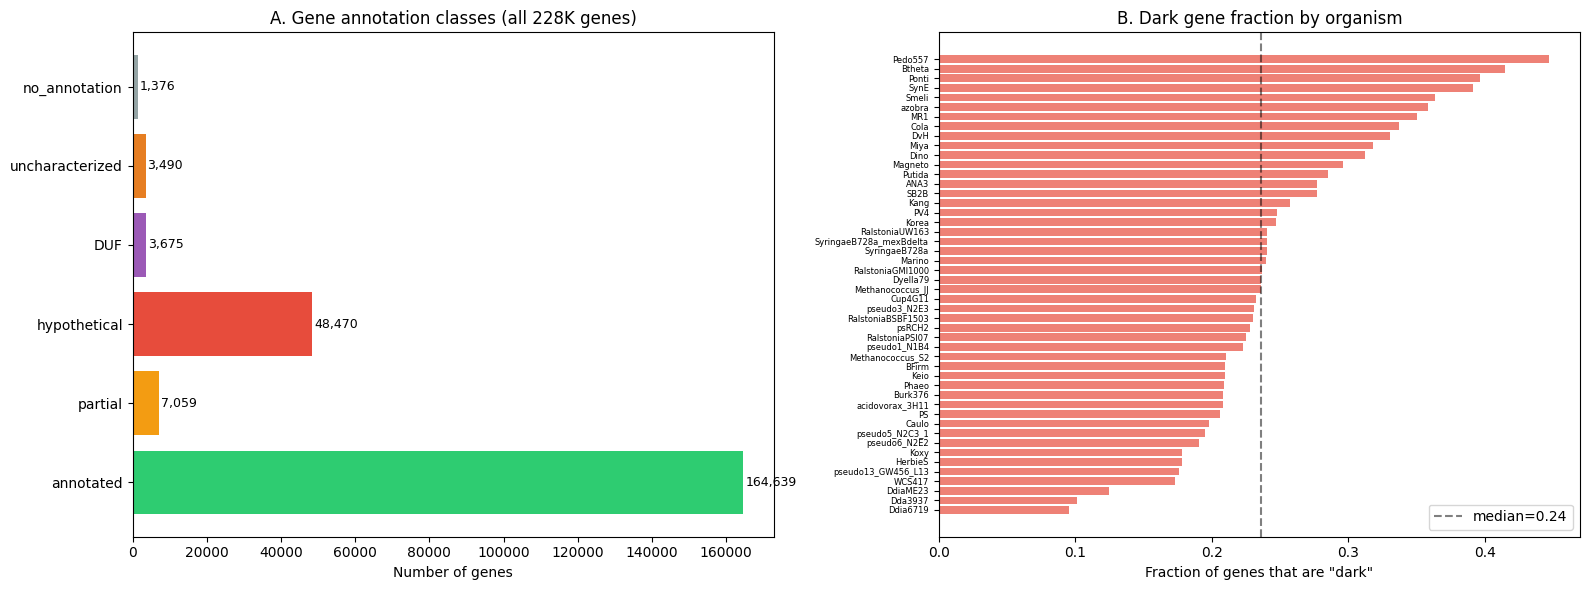

Saved: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/figures/fig01_annotation_breakdown.png


In [18]:
# Figure 1: Annotation class breakdown by organism
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Overall annotation breakdown
class_order = ['annotated', 'partial', 'hypothetical', 'DUF', 'uncharacterized', 'no_annotation']
colors = {'annotated': '#2ecc71', 'partial': '#f39c12', 'hypothetical': '#e74c3c', 
          'DUF': '#9b59b6', 'uncharacterized': '#e67e22', 'no_annotation': '#95a5a6'}
class_vals = fb_genes['annotation_class'].value_counts().reindex(class_order).fillna(0)
axes[0].barh(range(len(class_vals)), class_vals.values, color=[colors[c] for c in class_vals.index])
axes[0].set_yticks(range(len(class_vals)))
axes[0].set_yticklabels(class_vals.index)
axes[0].set_xlabel('Number of genes')
axes[0].set_title('A. Gene annotation classes (all 228K genes)')
for i, v in enumerate(class_vals.values):
    axes[0].text(v + 500, i, f'{int(v):,}', va='center', fontsize=9)

# Panel B: Dark fraction per organism
org_dark = fb_genes.groupby('orgId').agg(
    total=('locusId', 'count'),
    n_dark=('is_dark', 'sum')
).reset_index()
org_dark['dark_frac'] = org_dark['n_dark'] / org_dark['total']
org_dark = org_dark.sort_values('dark_frac', ascending=True)

axes[1].barh(range(len(org_dark)), org_dark['dark_frac'].values, color='#e74c3c', alpha=0.7)
axes[1].set_yticks(range(len(org_dark)))
axes[1].set_yticklabels(org_dark['orgId'].values, fontsize=6)
axes[1].set_xlabel('Fraction of genes that are "dark"')
axes[1].set_title('B. Dark gene fraction by organism')
axes[1].axvline(x=org_dark['dark_frac'].median(), color='black', linestyle='--', alpha=0.5, label=f'median={org_dark["dark_frac"].median():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig01_annotation_breakdown.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {os.path.join(FIG_DIR, 'fig01_annotation_breakdown.png')}")

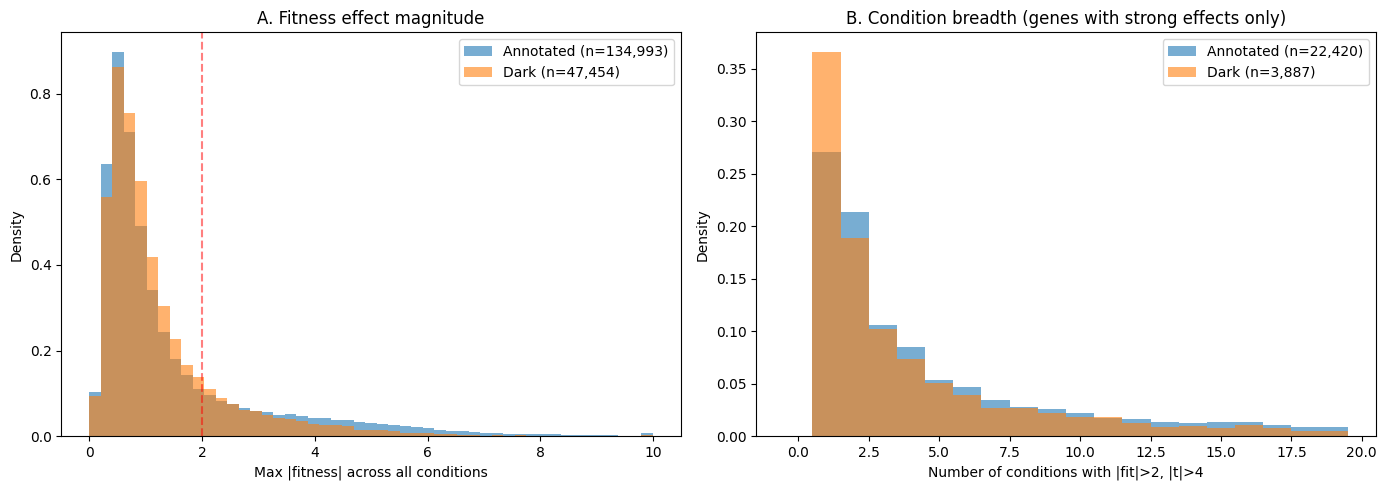

In [19]:
# Figure 2: Fitness effect distribution — dark vs annotated
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dark_fit = unified[unified['is_dark'] & unified['max_abs_fit'].notna()]
annot_fit = unified[(~unified['is_dark']) & unified['max_abs_fit'].notna()]

# Panel A: Max |fitness| distribution
bins = np.linspace(0, 10, 50)
axes[0].hist(annot_fit['max_abs_fit'].clip(upper=10), bins=bins, alpha=0.6, label=f'Annotated (n={len(annot_fit):,})', density=True)
axes[0].hist(dark_fit['max_abs_fit'].clip(upper=10), bins=bins, alpha=0.6, label=f'Dark (n={len(dark_fit):,})', density=True)
axes[0].set_xlabel('Max |fitness| across all conditions')
axes[0].set_ylabel('Density')
axes[0].set_title('A. Fitness effect magnitude')
axes[0].legend()
axes[0].axvline(x=2, color='red', linestyle='--', alpha=0.5, label='|fit|=2 threshold')

# Panel B: Number of strong conditions
max_cond = 20
bins_c = np.arange(0, max_cond + 1) - 0.5
dark_strong_conds = dark_fit[dark_fit['n_very_strong_conditions'] > 0]['n_very_strong_conditions'].clip(upper=max_cond)
annot_strong_conds = annot_fit[annot_fit['n_very_strong_conditions'] > 0]['n_very_strong_conditions'].clip(upper=max_cond)
axes[1].hist(annot_strong_conds, bins=bins_c, alpha=0.6, label=f'Annotated (n={len(annot_strong_conds):,})', density=True)
axes[1].hist(dark_strong_conds, bins=bins_c, alpha=0.6, label=f'Dark (n={len(dark_strong_conds):,})', density=True)
axes[1].set_xlabel('Number of conditions with |fit|>2, |t|>4')
axes[1].set_ylabel('Density')
axes[1].set_title('B. Condition breadth (genes with strong effects only)')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig02_fitness_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

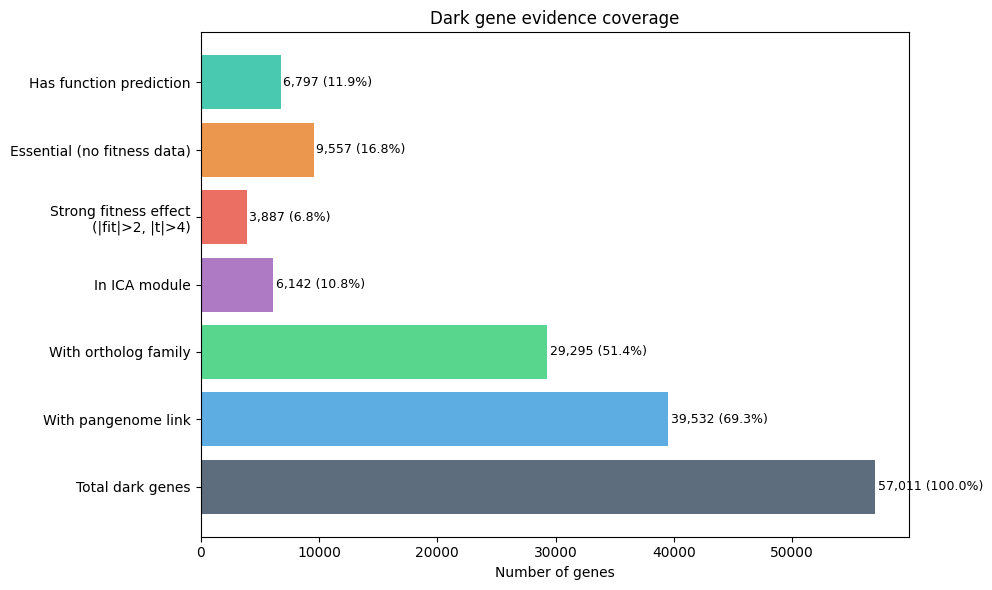

In [20]:
# Figure 3: Coverage Venn-like summary for dark genes
dark_only = unified[unified['is_dark']].copy()
n_dark = len(dark_only)
n_pangenome = dark_only['has_pangenome_link'].sum()
n_module = dark_only['in_module'].sum()
n_ortholog = dark_only['has_ortholog'].sum()
n_strong_fit = (dark_only['n_very_strong_conditions'] > 0).sum()
n_essential_dark = dark_only['is_essential_dark'].sum()
n_has_prediction = (dark_only['module_prediction'].notna() | dark_only['essential_prediction'].notna()).sum()

fig, ax = plt.subplots(figsize=(10, 6))
categories = ['Total dark genes', 'With pangenome link', 'With ortholog family',
              'In ICA module', 'Strong fitness effect\n(|fit|>2, |t|>4)', 
              'Essential (no fitness data)', 'Has function prediction']
values = [n_dark, n_pangenome, n_ortholog, n_module, n_strong_fit, n_essential_dark, n_has_prediction]
colors_bar = ['#34495e', '#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#e67e22', '#1abc9c']

bars = ax.barh(range(len(categories)), values, color=colors_bar, alpha=0.8)
ax.set_yticks(range(len(categories)))
ax.set_yticklabels(categories)
ax.set_xlabel('Number of genes')
ax.set_title('Dark gene evidence coverage')
for i, (v, total) in enumerate(zip(values, [n_dark]*len(values))):
    pct = 100 * v / total if total > 0 else 0
    ax.text(v + 200, i, f'{v:,} ({pct:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig03_dark_gene_coverage.png'), dpi=150, bbox_inches='tight')
plt.show()

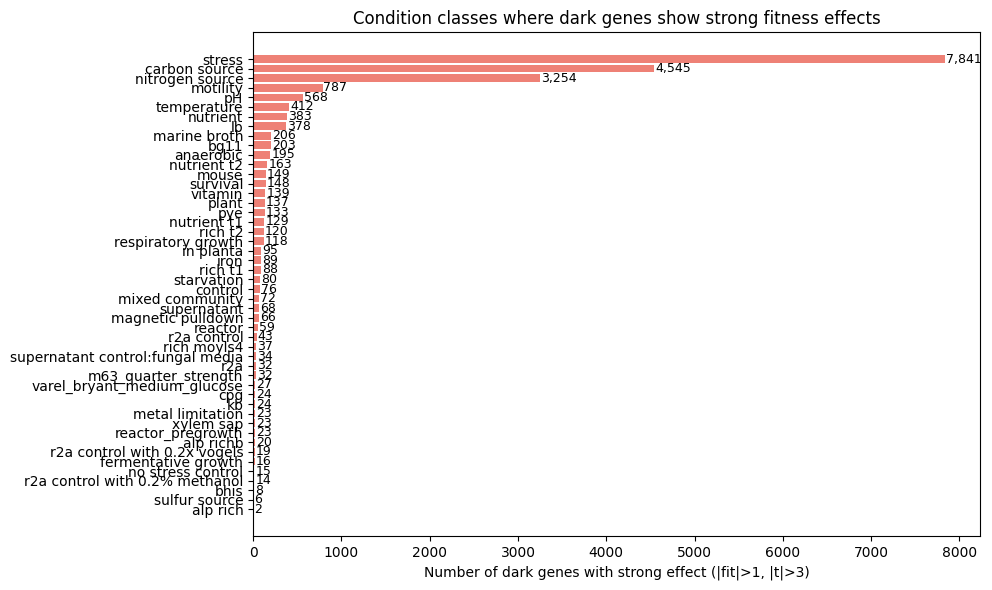

In [21]:
# Figure 4: Condition-class distribution for dark genes with strong phenotypes
dark_with_condition = condition_profile.merge(
    fb_genes[fb_genes['is_dark']][['orgId', 'locusId']], on=['orgId', 'locusId']
)

if len(dark_with_condition) > 0:
    group_counts = dark_with_condition.groupby('expGroup')['locusId'].nunique().sort_values(ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(group_counts)), group_counts.values, color='#e74c3c', alpha=0.7)
    ax.set_yticks(range(len(group_counts)))
    ax.set_yticklabels(group_counts.index)
    ax.set_xlabel('Number of dark genes with strong effect (|fit|>1, |t|>3)')
    ax.set_title('Condition classes where dark genes show strong fitness effects')
    for i, v in enumerate(group_counts.values):
        ax.text(v + 10, i, f'{v:,}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'fig04_condition_classes.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No condition-class data for dark genes")

## 5. Save Integrated Table

In [22]:
# Save the full unified table
output_path = os.path.join(DATA_DIR, 'dark_genes_integrated.tsv')
unified.to_csv(output_path, sep='\t', index=False)
print(f"Saved: {output_path}")
print(f"Shape: {unified.shape}")
print(f"Columns: {list(unified.columns)}")

# Also save dark-only subset for convenience
dark_output = os.path.join(DATA_DIR, 'dark_genes_only.tsv')
unified[unified['is_dark']].to_csv(dark_output, sep='\t', index=False)
print(f"\nSaved dark-only: {dark_output}")
print(f"Dark gene count: {unified['is_dark'].sum():,}")

Saved: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data/dark_genes_integrated.tsv
Shape: (228709, 43)
Columns: ['orgId', 'locusId', 'sysName', 'gene', 'desc', 'annotation_class', 'is_dark', 'max_abs_fit', 'min_fit', 'n_strong_conditions', 'n_very_strong_conditions', 'n_experiments', 'n_specific_phenotypes', 'top_condition_class', 'top_condition_fit', 'n_condition_classes', 'gene_cluster_id', 'gtdb_species_clade_id', 'pident', 'is_core', 'is_auxiliary', 'is_singleton', 'has_pangenome_link', 'module', 'in_module', 'familyId', 'OG_id', 'has_ortholog', 'essentiality_class', 'frac_essential', 'og_n_organisms', 'module_prediction', 'prediction_source', 'module_pred_confidence', 'essential_prediction', 'family_consensus', 'essential_pred_confidence', 'top_cofit_partners', 'top_cofit_score', 'n_domains', 'domain_dbs', 'domain_names', 'is_essential_dark']



Saved dark-only: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data/dark_genes_only.tsv
Dark gene count: 57,011


## 6. Summary Statistics

In [23]:
dark = unified[unified['is_dark']]

print("=" * 70)
print("NB01 SUMMARY: Functional Dark Matter Census")
print("=" * 70)
print(f"")
print(f"Total FB genes:                {len(unified):>10,}")
print(f"Dark genes:                    {len(dark):>10,} ({100*len(dark)/len(unified):.1f}%)")
print(f"  - hypothetical:              {(dark['annotation_class']=='hypothetical').sum():>10,}")
print(f"  - DUF:                       {(dark['annotation_class']=='DUF').sum():>10,}")
print(f"  - uncharacterized:           {(dark['annotation_class']=='uncharacterized').sum():>10,}")
print(f"  - no_annotation:             {(dark['annotation_class']=='no_annotation').sum():>10,}")
print(f"")
print(f"--- Fitness evidence ---")
print(f"Dark with any fitness data:    {(dark['n_experiments'].notna() & (dark['n_experiments'] > 0)).sum():>10,}")
print(f"Dark with strong effect:       {(dark['n_strong_conditions'] > 0).sum():>10,}")
print(f"Dark with very strong effect:  {(dark['n_very_strong_conditions'] > 0).sum():>10,}")
print(f"Dark with specific phenotype:  {(dark['n_specific_phenotypes'] > 0).sum():>10,}")
print(f"Dark essential (no mutants):   {dark['is_essential_dark'].sum():>10,}")
print(f"")
print(f"--- Cross-references ---")
print(f"Dark with pangenome link:      {dark['has_pangenome_link'].sum():>10,}")
print(f"Dark in ICA module:            {dark['in_module'].sum():>10,}")
print(f"Dark with ortholog family:     {dark['has_ortholog'].sum():>10,}")
print(f"Dark with module prediction:   {dark['module_prediction'].notna().sum():>10,}")
print(f"Dark with essential prediction:{dark['essential_prediction'].notna().sum():>10,}")
print(f"Dark with domain annotations:  {dark['n_domains'].notna().sum():>10,}")
print(f"Dark with co-fitness partners: {dark['top_cofit_partners'].notna().sum():>10,}")
print(f"")
print(f"--- High-priority dark genes ---")
hp = dark[
    (dark['n_very_strong_conditions'] > 0) | 
    (dark['is_essential_dark'])
]
print(f"Total high-priority (strong fitness OR essential): {len(hp):,}")
print(f"  With pangenome link:         {hp['has_pangenome_link'].sum():>10,}")
print(f"  With ortholog family:        {hp['has_ortholog'].sum():>10,}")
print(f"  With function prediction:    {(hp['module_prediction'].notna() | hp['essential_prediction'].notna()).sum():>10,}")
print("=" * 70)

NB01 SUMMARY: Functional Dark Matter Census

Total FB genes:                   228,709
Dark genes:                        57,011 (24.9%)
  - hypothetical:                  48,470
  - DUF:                            3,675
  - uncharacterized:                3,490
  - no_annotation:                  1,376

--- Fitness evidence ---
Dark with any fitness data:        47,454
Dark with strong effect:           12,065
Dark with very strong effect:       3,887
Dark with specific phenotype:       2,551
Dark essential (no mutants):        9,557

--- Cross-references ---
Dark with pangenome link:          39,532
Dark in ICA module:                 6,142
Dark with ortholog family:         29,295
Dark with module prediction:        5,424
Dark with essential prediction:     1,373
Dark with domain annotations:      27,870
Dark with co-fitness partners:      8,351

--- High-priority dark genes ---
Total high-priority (strong fitness OR essential): 13,444
  With pangenome link:              8,438
  Wit